In [38]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import numpy.matlib
from matplotlib import cm
import netCDF4 as nc
import pandas as pd
from matplotlib.patches import Rectangle
from scipy.stats import chisquare
import scipy
from gmt_plot import gmt_plot

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb

from datetime import datetime

### load VGG and gravity
* region: -180/180/-80/180
* resolution: 1 min
* VGG: unit Etovos </br>
    * https://topex.ucsd.edu/pub/global_grav_1min/curv.32.1.nc
    * gmt grd2xyz curv.32.1.nc > curv.xyz
* gravity: unit mGal </br>
    * https://topex.ucsd.edu/pub/global_grav_1min/grav.32.1.nc
    * gmt grd2xyz curv.32.1.nc > curv.xyz

In [15]:
add = '/Users/seamount_picking/data/'
fname = 'curv.xyz'
df = pd.read_csv(add + fname, sep='\t', names=["lon", "lat", "VGG"])
lon = df['lon'].to_numpy()
lat = df['lat'].to_numpy()
VGG = df['VGG'].to_numpy()

fname = 'grav.xyz'
df = pd.read_csv(add + fname, sep='\t', names=["lon", "lat", "gravity"])
gravity = df['gravity'].to_numpy()

lon_nc = np.linspace(start=-179.991666667, stop=179.991666667, num=21600)
lat_nc = np.linspace(start=79.99166666666669, stop=-79.99166666666669, num=9600)

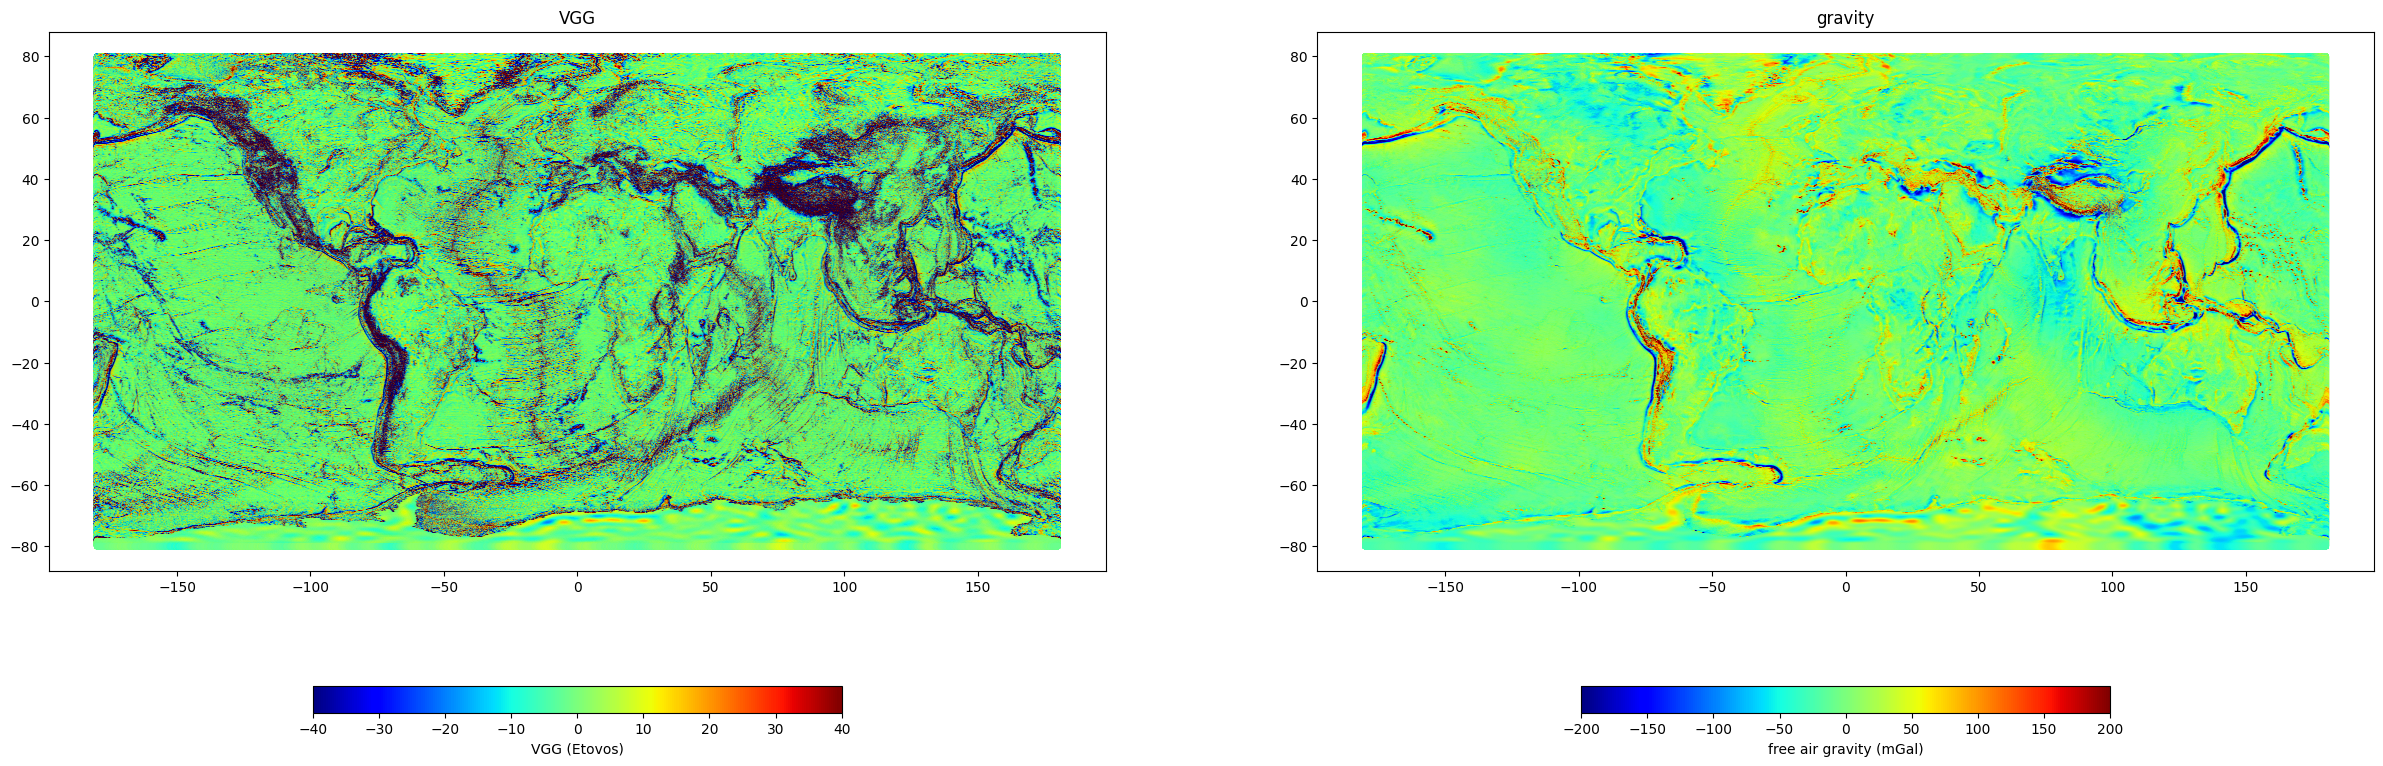

In [14]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
sc = plt.scatter(lon,lat, c=VGG, vmin=-40, vmax = 40, cmap='gray', s=20, edgecolors='none')
# And let's include that colorbar
cbar = plt.colorbar(sc, shrink = .5, orientation='horizontal')
cbar.set_label('VGG (Etovos)')
plt.title('VGG')

plt.subplot(1, 2, 2)
sc = plt.scatter(lon,lat, c=gravity, vmin=-200, vmax = 250, cmap='jet', s=20, edgecolors='none')
cbar = plt.colorbar(sc, shrink = .5, orientation='horizontal')
cbar.set_label('free air gravity (mGal)')
plt.title('gravity')
plt.show()

### load SID and bathymetry

### store everything in pandas dataframe

In [16]:
# del df_origin
df_origin = pd.DataFrame({'lon': lon.flatten(),
                   'lat': lat.flatten(),
                   'VGG': VGG.flatten(),
                   'gravity': gravity.flatten(),
                   'seamount': 0,
                  })

In [24]:
scaler = RobustScaler(with_centering = True)
scaler2 = MinMaxScaler(feature_range=(-1, 1))

VGG_n = scaler.fit_transform(df_origin.VGG.values.reshape(-1,1))
gravity_n = scaler.fit_transform(df_origin.gravity.values.reshape(-1,1))
lon_n = scaler2.fit_transform(df_origin.lon.values.reshape(-1,1))
lat_n = scaler2.fit_transform(df_origin.lat.values.reshape(-1,1))

### create labels using handpicked seamount locations by Julie
* 0: ocean
* 1: center of seamounts
* 2: within radius of a seamount

In [17]:
seamount_info = pd.read_excel('../data/sample_mask.txt.xlsx')


In [18]:
seamount_info

Longitude   Latitude  VGG Height   Radius   base_depth  -        Name  \
0       50.908333 -46.358333        2600  18.9228  -529.481323  1    KW-04000   
1      -17.391667  56.408333        2600  18.9228  -816.719849  1   SIO-00288   
2       50.941667 -46.625000        2600  18.9228  -887.615417  1    KW-04009   
3      -17.658333  57.975000        2600  18.9228  -963.632568  1   SIO-00284   
4      153.991667  49.091667        2600  18.9228  -978.578918  1   SIO-05217   
...           ...        ...         ...      ...          ... ..         ...   
43514  146.175000  31.875000         800   5.8224 -6078.007324  1   SIO-00883   
43515  126.725000  10.891667        1600  11.6448 -6939.002930  1    KW-22105   
43516  159.458333  49.791667         600   4.3668 -5977.937012  1  SIO2-00335   
43517  146.475000  12.991667        2200  16.0116 -7793.446289  1    KW-16044   
43518  145.841667  12.591667        1700  12.3726 -7650.500488  1    KW-16063   

       Charted  surface_depth  
0            0    2070.518677  
1            1    1783.280151  
2            0    1712.384583  
3            1    1636.367432  
4            0    1621.421082  
...        ...            ...  
43514        1   -5278.007324  
43515        1   -5339.002930  
43516        0   -5377.937012  
43517        1   -5593.446289  
43518        1   -5950.500488  

[43519 rows x 9 columns]

### assign 1 to seamount center, default 0 -- ocean

In [19]:
for i in range(len(seamount_info)):
    lon = seamount_info.Longitude[i]
    lat = seamount_info.Latitude[i]
    difference_lon = np.absolute(lon_nc-lon)
    difference_lat = np.absolute(lat_nc-lat)
    index_lon = difference_lon.argmin()
    index_lat = difference_lat.argmin()
    index = index_lon+index_lat*21600
    df_origin.loc[index, 'seamount'] = 1


In [20]:
df_origin

lon        lat       VGG    gravity  seamount
0         -179.991667  79.991667  0.335805  13.293900         0
1         -179.975000  79.991667  1.274943  13.624750         0
2         -179.958333  79.991667  1.872657  13.963760         0
3         -179.941667  79.991667  2.089677  14.263420         0
4         -179.925000  79.991667  2.144011  14.527278         0
...               ...        ...       ...        ...       ...
207359995  179.925000 -79.991667 -1.749126 -24.739250         0
207359996  179.941667 -79.991667 -1.749126 -24.779335         0
207359997  179.958333 -79.991667 -1.749126 -24.779335         0
207359998  179.975000 -79.991667 -1.712476 -24.814579         0
207359999  179.991667 -79.991667 -1.715178 -24.809874         0

[207360000 rows x 5 columns]

In [63]:
df = pd.DataFrame({'lon': df_origin.lon,
                   'lat': df_origin.lat,
                   'VGG': VGG_n.flatten(),
                   'gravity': gravity_n.flatten(),
                   'seamount': df_origin.seamount,
                   })
df.shape

(207360000, 5)

In [8]:
df_training = df_origin[(df_origin['lat']<=33)&(df_origin['lat']>=26)&(df_origin['lon']<=-122)&(df_origin['lon']>=-132)]
df_validation = df_origin[(df_origin['lat']<=36.5)&(df_origin['lat']>=32.5)&(df_origin['lon']<=-137)&(df_origin['lon']>=-150)]
df_test = df_origin[(df_origin['lat']<=-1.5)&(df_origin['lat']>=-6)&(df_origin['lon']<=-91)&(df_origin['lon']>=-98)]

In [64]:
df_training = df[(df['lat']<=33)&(df['lat']>=26)&(df['lon']<=-122)&(df['lon']>=-132)]
df_validation = df[(df['lat']<=36.5)&(df['lat']>=32.5)&(df['lon']<=-137)&(df['lon']>=-150)]
df_test = df[(df['lat']<=-1.5)&(df['lat']>=-6)&(df['lon']<=-91)&(df['lon']>=-98)]

Text(0.5, 1.0, 'VGG (training site)')

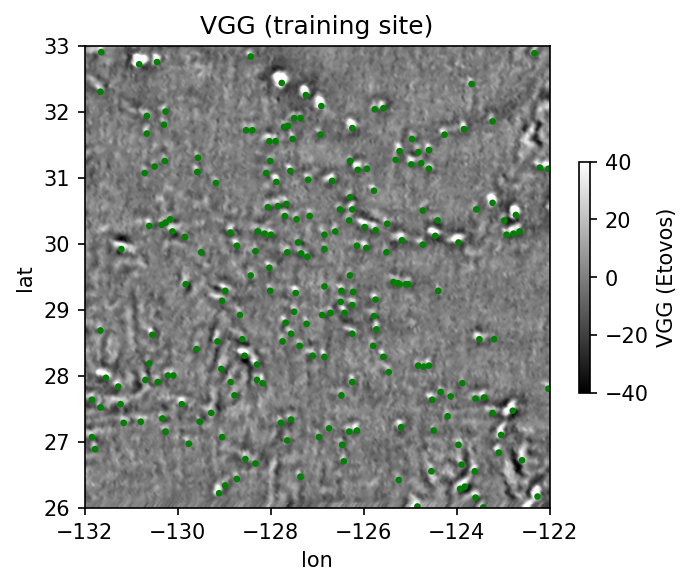

In [11]:
plt.figure(figsize=(5, 4), dpi = 150)
sc = plt.scatter(df_training.lon,df_training.lat, c=df_training.VGG, vmin=-40, vmax = 40, cmap='gray', s=20, edgecolors='none')
cbar = plt.colorbar(sc, shrink = .5, orientation='vertical')
df_training_sub = df_training[df_training.seamount==1]
sc_seamount = plt.scatter(df_training_sub.lon,df_training_sub.lat, c='green', marker='o', s=10, edgecolors='none')
cbar.set_label('VGG (Etovos)')
plt.xlabel('lon')
plt.ylabel('lat')
plt.xlim([-132, -122])
plt.ylim([26, 33])
plt.title('VGG (training site)')

Text(0.5, 1.0, 'VGG (validation site)')

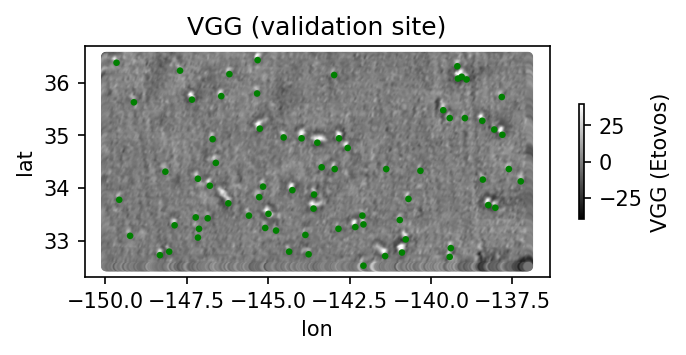

In [12]:
plt.figure(figsize=(5, 2), dpi = 150)
sc = plt.scatter(df_validation.lon,df_validation.lat, c=df_validation.VGG, vmin=-40, vmax = 40, cmap='gray', s=20, edgecolors='none')
cbar = plt.colorbar(sc, shrink = .5, orientation='vertical')
df_validation_sub = df_validation[df_validation.seamount==1]
sc_seamount = plt.scatter(df_validation_sub.lon,df_validation_sub.lat, c='green', marker='o', s=10, edgecolors='none')
cbar.set_label('VGG (Etovos)')
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('VGG (validation site)')

Text(0.5, 1.0, 'VGG (test site)')

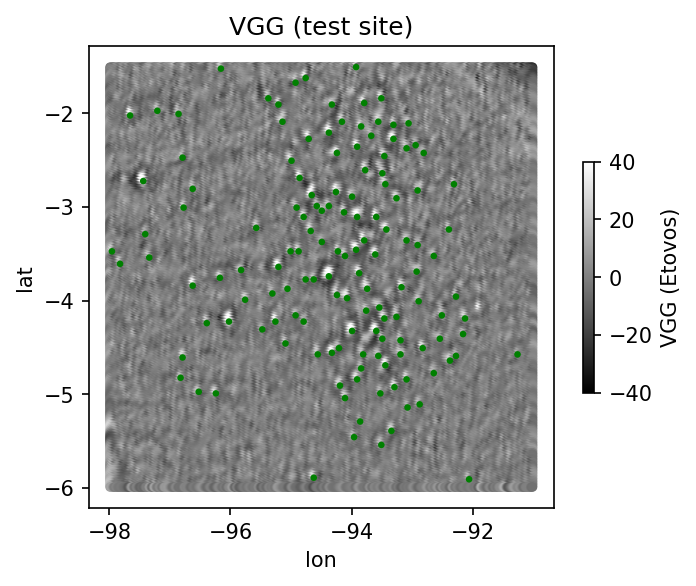

In [13]:
plt.figure(figsize=(5, 4), dpi = 150)
sc = plt.scatter(df_test.lon,df_test.lat, c=df_test.VGG, vmin=-40, vmax = 40, cmap='gray', s=20, edgecolors='none')
cbar = plt.colorbar(sc, shrink = .5, orientation='vertical')
df_test_sub = df_test[df_test.seamount==1]
sc_seamount = plt.scatter(df_test_sub.lon,df_test_sub.lat, c='green', marker='o', s=10, edgecolors='none')
cbar.set_label('VGG (Etovos)')
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('VGG (test site)')

### train a simple classfication model

In [37]:
import warnings
warnings.filterwarnings("ignore")

In [67]:
feature_name = ['VGG', 'gravity']

In [68]:
clf = lgb.LGBMClassifier(force_row_wise=True)
clf.fit(df_training[feature_name], df_training[['seamount']])

[LightGBM] [Info] Number of positive: 225, number of negative: 251775
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 252000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000893 -> initscore=-7.020191
[LightGBM] [Info] Start training from score -7.020191


LGBMClassifier(force_row_wise=True)

In [69]:
y_pred_train = clf.predict(df_training[feature_name])
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(df_training[['seamount']], y_pred_train)))

Training-set accuracy score: 0.9991


In [70]:
# making predictions
y_pred=clf.predict(df_test[feature_name])
# view accuracy
accuracy=accuracy_score(y_pred, df_test[['seamount']])
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(df_test[['seamount']], y_pred)))

LightGBM Model accuracy score: 0.9988


In [71]:
df_test_pred = pd.DataFrame({'lon':df_test.lon, 'lat':df_test.lat, 'seamount':y_pred})
df_test_pred_sub = df_test_pred[df_test_pred.seamount==1]
df_test_pred_sub

Empty DataFrame
Columns: [lon, lat, seamount]
Index: []

Text(0.5, 1.0, 'VGG (test site prediction)')

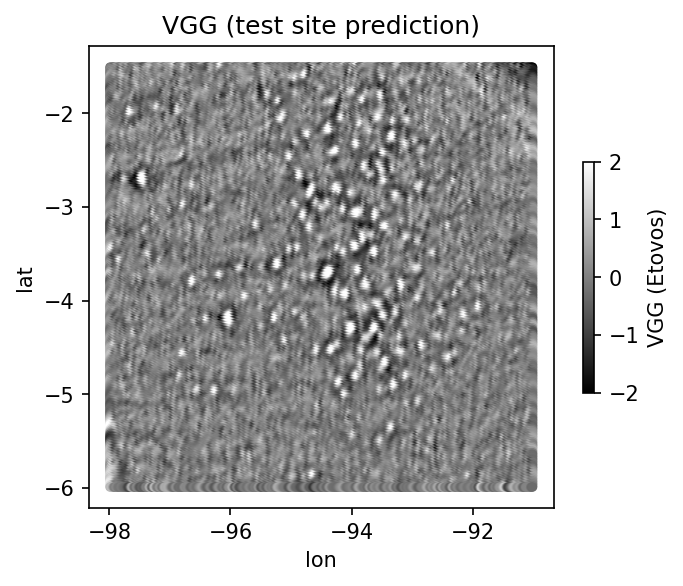

In [72]:
plt.figure(figsize=(5, 4), dpi = 150)
sc = plt.scatter(df_test.lon,df_test.lat, c=df_test.VGG, vmin=-2, vmax = 2, cmap='gray', s=20, edgecolors='none')
cbar = plt.colorbar(sc, shrink = .5, orientation='vertical')
sc_seamount = plt.scatter(df_test_pred_sub.lon,df_test_pred_sub.lat, c='green', marker='o', s=10, edgecolors='none')
cbar.set_label('VGG (Etovos)')
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('VGG (test site prediction)')

### exclude land and ridges

### normalize features

### select training, validation, and test datasets